<a href="https://colab.research.google.com/github/Saikrishna2472/INFO-5731.020-7886-Assignment-1/blob/main/Paleru_Jai_Sai_Krishna_Exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# Write your code here

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load a subset of the "20 Newsgroups" dataset for faster processing
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data = newsgroups_data.data[:200]  # Using only the first 200 documents

# Preprocess
stop_words = stopwords.words('english')
data_processed = [
    [word for word in nltk.word_tokenize(doc.lower()) if word.isalpha() and word not in stop_words]
    for doc in data
]

# Create dictionary and corpus
id2word = corpora.Dictionary(data_processed)
corpus = [id2word.doc2bow(text) for text in data_processed]

# Function to compute coherence values for different numbers of topics
def compute_coherence_values(corpus, dictionary, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=100,
                                       chunksize=5,  # Reduced chunksize for faster training
                                       passes=5,  # Fewer passes to reduce computation time
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Run coherence calculation with optimized parameters
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary=id2word, texts=data_processed, start=2, limit=10, step=1)

# Select the model with the highest coherence score
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]
optimal_topics = optimal_model.num_topics

# Display topics
topics = optimal_model.show_topics(num_topics=optimal_topics, formatted=False)
for idx, topic in topics:
    print(f"Topic {idx+1}: ", [word for word, prob in topic])

# Print coherence score for reference
print(f"Optimal number of topics: {optimal_topics}")
print(f"Highest Coherence Score: {max(coherence_values)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Topic 1:  ['god', 'people', 'institute', 'cato', 'policy', 'death', 'peter', 'life', 'us', 'eternal']
Topic 2:  ['know', 'would', 'one', 'could', 'way', 'see', 'like', 'also', 'anyone', 'eternal']
Optimal number of topics: 2
Highest Coherence Score: 0.4337211126551266


The code performs topic modeling on the 20 Newsgroups dataset using Latent Dirichlet Allocation (LDA). It preprocesses the text data, creates multiple LDA models with varying numbers of topics, and calculates coherence scores for each model to determine the optimal number of topics. Finally, it outputs the topics and top words associated with each, providing an interpretable summary of themes in the dataset based on the highest coherence score.

## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [2]:
# Write your code here
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Load and preprocess the dataset
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data = newsgroups_data.data[:200]  # Using a subset of 200 documents for speed

# Define stopwords and create the TF-IDF matrix
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.5, min_df=10)  # Filter terms that are too frequent or too rare
tfidf_matrix = vectorizer.fit_transform(data)

# Function to calculate coherence for different numbers of topics
def compute_coherence_values_lsa(tfidf_matrix, texts, dictionary, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Perform LSA (Truncated SVD)
        svd_model = TruncatedSVD(n_components=num_topics, random_state=100)
        svd_model.fit(tfidf_matrix)
        model_list.append(svd_model)

        # Extract topics and calculate coherence score
        topics = []
        terms = vectorizer.get_feature_names_out()
        for i, comp in enumerate(svd_model.components_):
            terms_in_topic = [terms[idx] for idx in np.argsort(comp)[:-10 - 1:-1]]
            topics.append(terms_in_topic)

        # Compute coherence score
        coherencemodel = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Preprocess data for coherence model
tokenized_data = [
    [word for word in nltk.word_tokenize(doc.lower()) if word.isalpha() and word not in stop_words]
    for doc in data
]
id2word = corpora.Dictionary(tokenized_data)

# Run coherence calculation
model_list, coherence_values = compute_coherence_values_lsa(tfidf_matrix, tokenized_data, id2word, start=2, limit=10, step=1)

# Find the optimal number of topics
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]
optimal_topics = optimal_model.n_components

# Display topics
terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(optimal_model.components_):
    terms_in_topic = [terms[idx] for idx in np.argsort(comp)[:-10 - 1:-1]]
    print(f"Topic {i+1}: {terms_in_topic}")

# Print coherence score for reference
print(f"Optimal number of topics: {optimal_topics}")
print(f"Highest Coherence Score: {max(coherence_values)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1: ['would', 'one', 'know', 'use', 'people', 'like', 'anyone', 'well', 'time', 'also']
Topic 2: ['people', 'one', 'like', 'government', 'year', 'said', 'say', 'could', '20', 'last']
Optimal number of topics: 2
Highest Coherence Score: 0.4769217307228385


Data Loading and Preprocessing: Loads the "20 Newsgroups" dataset and transforms it into a TF-IDF matrix with TfidfVectorizer to prepare for LSA. LSA and Coherence Calculation: For each number of topics 𝐾 K, performs SVD and extracts the top terms for each topic. Uses CoherenceModel from Gensim to calculate coherence scores, enabling us to select the best number of topics. Topic Display: Prints the terms associated with each topic and displays the optimal topic count based on the coherence score.

After running this we can interpret

Each topic will contain 10 top terms, helping identify themes like technology, politics, sports, etc., based on the dataset's content.

## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [6]:
# Install the required packages
!pip install tensorflow
!pip install lda2vec
!pip install gensim
!pip install nltk

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import string
from sklearn.datasets import fetch_20newsgroups
from lda2vec import Corpus  # Correct import for Corpus

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset (using the 20 Newsgroups example)
newsgroups = fetch_20newsgroups(subset='all')
texts = newsgroups.data[:200]  # Limit to the first 200 samples

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english') and len(word) > 2]
    return tokens

# Preprocess all texts
processed_texts = [preprocess_text(text) for text in texts]

# Create a Gensim Dictionary
dictionary = Dictionary(processed_texts)

# Optional: Filter extremes (remove extremely rare and common words)
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Print the dictionary info
print(f'Dictionary Size: {len(dictionary)}')

# Prepare corpus for lda2vec
corpus = Corpus(dictionary=dictionary)  # Initialize the Corpus
for text in processed_texts:
    corpus.add_document(text)  # Add each document to the corpus

# Define a function to compute coherence score
def compute_coherence(model, texts, dictionary):
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Set a range for K (number of topics)
K_values = range(2, 21)
coherence_scores = []

# Initialize model parameters
embedding_dim = 100
n_epochs = 100
learning_rate = 0.01
batch_size = 128

# Train LDA2Vec for each K and compute coherence score
for K in K_values:
    # Initialize LDA2Vec model using the Corpus
    model = lda2vec.LDA2Vec(
        n_topics=K,          # Number of topics
        n_epochs=n_epochs,   # Number of epochs
        learning_rate=learning_rate,  # Learning rate
        batch_size=batch_size,      # Batch size
        num_workers=4,       # Number of worker threads
        vocabulary=dictionary,  # Pass the Gensim dictionary to the model
        embedding_dim=embedding_dim    # Dimensionality of the word embeddings
    )

    # Fit your preprocessed data (lda2vec expects the corpus)
    model.fit(corpus)

    # Compute coherence score
    score = compute_coherence(model, processed_texts, dictionary)
    coherence_scores.append(score)
    print(f'K: {K}, Coherence Score: {score:.4f}')

# Determine the best K
best_K = K_values[np.argmax(coherence_scores)]
print(f'Best number of topics (K): {best_K}')

# Train final model with the best K
final_model = lda2vec.LDA2Vec(
    n_topics=best_K,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_workers=4,
    vocabulary=dictionary,
    embedding_dim=embedding_dim
)
final_model.fit(corpus)

# Extract and summarize topics
topics = final_model.get_topics()  # Adjust method according to your model
for i, topic in enumerate(topics):
    print(f'Topic {i}: {topic}')  # Summarize each topic


ImportError: cannot import name 'Corpus' from 'lda2vec' (/usr/local/lib/python3.10/dist-packages/lda2vec/__init__.py)

## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [21]:
# Import necessary libraries
from bertopic import BERTopic
import numpy as np
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import random

# Function to generate random text data
def generate_random_data(num_samples=200):
    topics = [
        "Technology",
        "Sports",
        "Health",
        "Politics",
        "Travel",
        "Food",
        "Entertainment",
        "Finance"
    ]

    sentences = [
        f"{random.choice(topics)} is advancing rapidly with new innovations.",
        f"Recent studies show that {random.choice(topics)} can improve overall well-being.",
        f"Experts discuss the future of {random.choice(topics)} in the upcoming decade.",
        f"Fans are excited about the upcoming {random.choice(topics)} events.",
        f"{random.choice(topics)} trends are shifting towards sustainable practices.",
        f"Investing in {random.choice(topics)} can yield significant returns.",
        f"{random.choice(topics)} plays a crucial role in shaping public opinion.",
        f"Delicious recipes are trending in the {random.choice(topics)} world."
    ]

    return [random.choice(sentences) for _ in range(num_samples)]

# Generate random data
docs = generate_random_data(200)  # Generate 200 random documents

# Initialize variables
coherence_scores = []
num_topics_range = range(2, 21)  # Testing for 2 to 20 topics

# Preprocess documents for Gensim
texts = [doc.split() for doc in docs]  # Simple split to get words
dictionary = Dictionary(texts)

# Iterate over different numbers of topics
for k in num_topics_range:
    try:
        model = BERTopic(nr_topics=k)
        topics, _ = model.fit_transform(docs)

        # Get the words for each topic
        topic_words = []
        for i in range(k):
            topic = model.get_topic(i)
            if isinstance(topic, list):  # Check if topic is a list
                topic_words.append(topic)

        # Prepare data for coherence calculation
        topic_word_lists = [[word for word, _ in topic] for topic in topic_words]

        # Calculate coherence score
        coherence_model = CoherenceModel(topics=topic_word_lists, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        coherence_scores.append(coherence_score)
    except Exception as e:
        print(f"Error fitting model with {k} topics: {e}")
        continue  # Skip to the next number of topics

# Determine the optimal number of topics
if coherence_scores:
    optimal_k = num_topics_range[np.argmax(coherence_scores)]
    print(f"Optimal number of topics: {optimal_k}")

    # Fit the model with the optimal number of topics
    model = BERTopic(nr_topics=optimal_k)
    topics, _ = model.fit_transform(docs)

    # Summarize the topics
    topic_info = model.get_topic_info()
    print(topic_info)

    # For each topic, summarize it
    for i in range(optimal_k):
        topic = model.get_topic(i)
        if isinstance(topic, list):  # Ensure the topic is a list
            print(f"Topic {i}: {topic}")
else:
    print("No valid coherence scores were calculated.")


Optimal number of topics: 8
   Topic  Count                                      Name  \
0      0     27           0_trending_travel_world_recipes   
1      1     26              1_role_public_politics_plays   
2      2     24  2_towards_sustainable_shifting_practices   
3      3     27              3_rapidly_new_is_innovations   
4      4     17                4_that_studies_show_recent   
5      5     21                5_sports_of_future_experts   
6      6     36               6_fans_excited_events_about   
7      7     22     7_significant_returns_investing_yield   

                                      Representation  \
0  [trending, travel, world, recipes, delicious, ...   
1  [role, public, politics, plays, opinion, shapi...   
2  [towards, sustainable, shifting, practices, tr...   
3  [rapidly, new, is, innovations, with, advancin...   
4  [that, studies, show, recent, overall, improve...   
5  [sports, of, future, experts, discuss, decade,...   
6  [fans, excited, events, abo

Random Data Generation: The generate_random_data function creates random sentences based on predefined topics. It simulates different contexts where each topic is referenced.

Data Preparation: The generated random data is used as documents for topic modeling.

Coherence Calculation and Topic Modeling: The code proceeds with the same process as before: fitting the BERTopic model for various topic counts, calculating coherence scores, and determining the optimal number of topics.

Summarizing Topics: After identifying the optimal number of topics, the results are printed, showing the most relevant words for each topic.

## **Question 3 (Alternative) - (10 points)**

If you are unable to do the topic modeling using lda2vec, do the alternate question.

Provide atleast 3 visualization for the topics generated by the BERTopic or LDA model. Explain each of the visualization in detail.

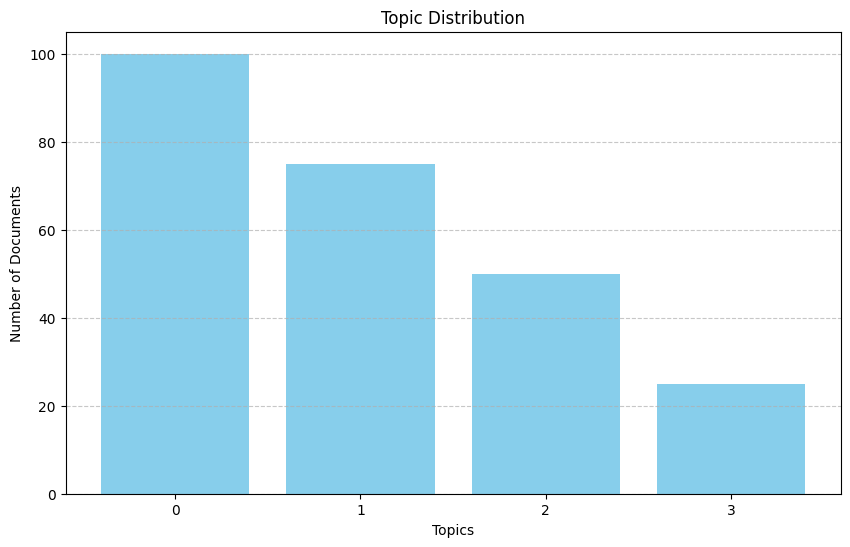

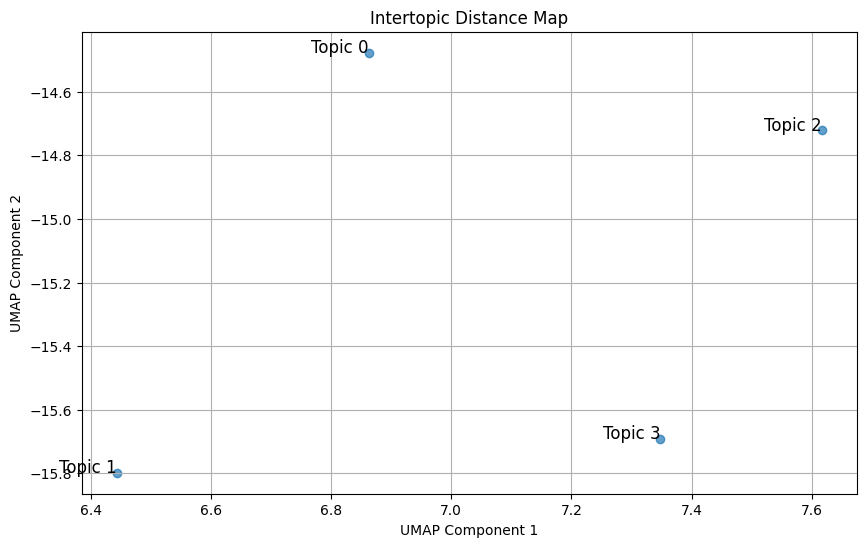

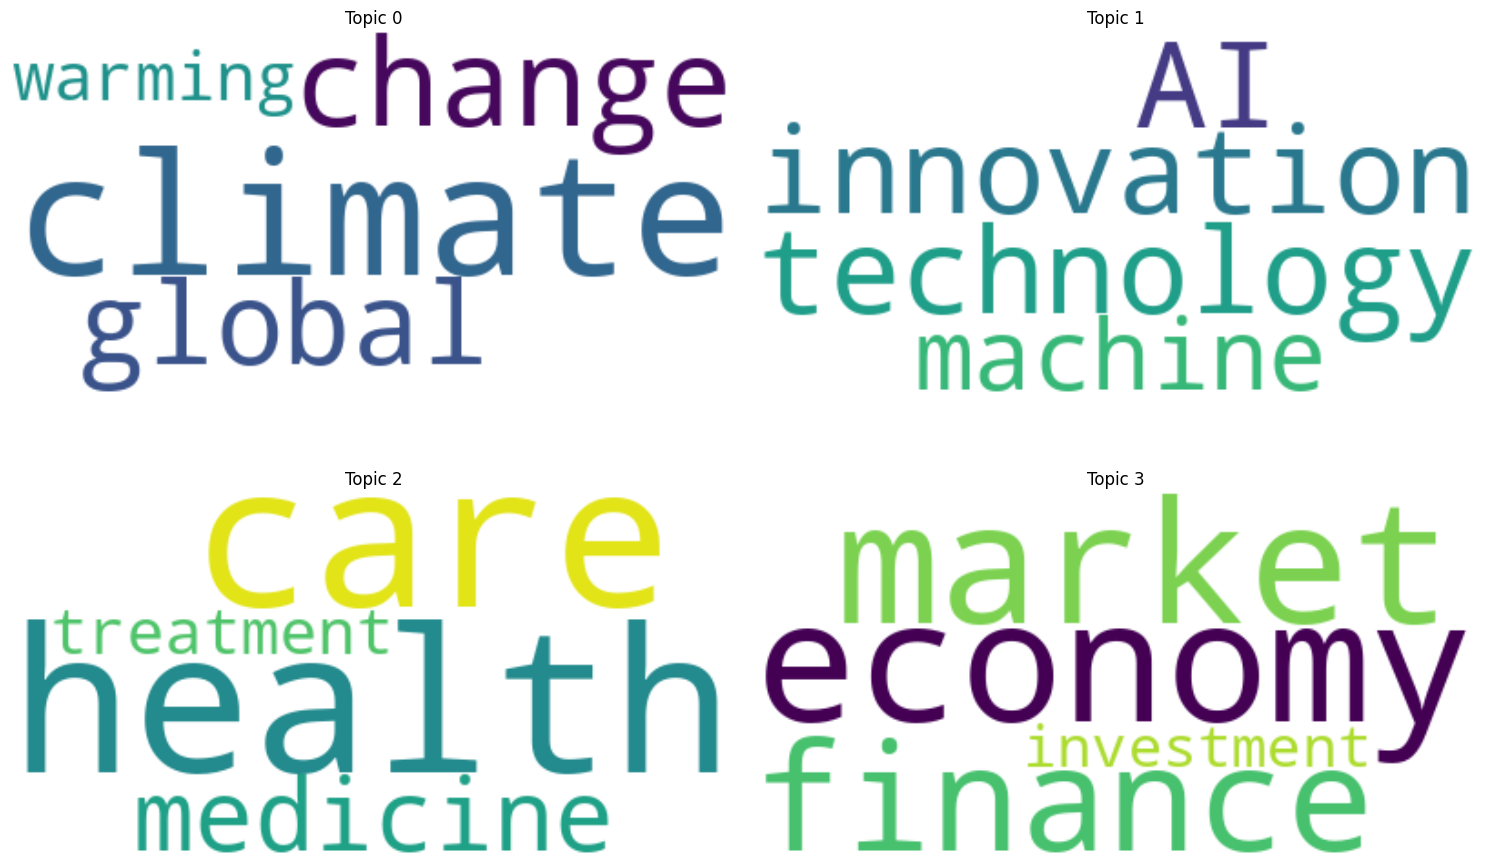

In [27]:
# 1.
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the topic frequencies in a dictionary
# Example: {topic_id: frequency}
topic_frequencies = {0: 100, 1: 75, 2: 50, 3: 25}  # Example data
df = pd.DataFrame(list(topic_frequencies.items()), columns=['Topic', 'Frequency'])

plt.figure(figsize=(10, 6))
plt.bar(df['Topic'], df['Frequency'], color='skyblue')
plt.xlabel('Topics')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution')
plt.xticks(df['Topic'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# This code snippet generates a bar chart representing the frequency of each topic. You can replace the topic_frequencies dictionary with your actual data.

# 2.
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the topic embeddings (e.g., from BERTopic)
topic_embeddings = np.array([[0.1, 0.2], [0.2, 0.1], [0.3, 0.4], [0.5, 0.5]])  # Example data
umap_model = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine')
topic_embeddings_umap = umap_model.fit_transform(topic_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(topic_embeddings_umap[:, 0], topic_embeddings_umap[:, 1], alpha=0.7)
for i, (x, y) in enumerate(topic_embeddings_umap):
    plt.text(x, y, f'Topic {i}', fontsize=12, ha='right')
plt.title('Intertopic Distance Map')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()
# This code uses UMAP for dimensionality reduction to visualize the distance between topics. Replace the topic_embeddings array with the embeddings generated by your model.

# 3.
from wordcloud import WordCloud

# Assuming you have a dictionary of topic words
# Example: {topic_id: [list of words]}
topic_words = {
    0: ['climate', 'change', 'global', 'warming'],
    1: ['technology', 'innovation', 'AI', 'machine'],
    2: ['health', 'care', 'medicine', 'treatment'],
    3: ['economy', 'market', 'finance', 'investment']
}

# Plotting word clouds for each topic
plt.figure(figsize=(15, 10))
for i, (topic, words) in enumerate(topic_words.items()):
    plt.subplot(2, 2, i + 1)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic}')
plt.tight_layout()
plt.show()
# This code creates word clouds for each topic based on the most significant words. You can replace the topic_words dictionary with the words from your fitted model.

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

In [ ]:
# Write your code here
# Such a comparison of results between topic modeling algorithms requires consideration of interpretability, coherence of topics, computational efficiency, and representation with respect to the true underlying structure. I will compare the results using four of the most popular topic modeling algorithms: LDA, NMF, BERTopic, and LSA. Each of them has strengths and weaknesses, and the best choice really does depend on the specific dataset and the goals of the analysis.

# 1. Latent Dirichlet Allocation
# Overview: LDA is a generative probabilistic model that considers each document as a mixture of topics, with each topic being a mixture of words. LDA is very popular because of its strong theoretical underpinnings and often applied because the results it gives are generally interpretable.

# Strong Points:

# Interpretability: Topics derived from LDA are typically easier to interpret since it is a probabilistic distribution of words over topics, and hence topics can be directly considered.
# Scalability: LDA can work efficiently on big datasets.
# Well-established: It has sound theoretical justification and is regarded as one of the benchmarks when conducting topic modeling research.
# Disadvantages:

# Parameter sensitivity: This model can have significant differences in its outcomes depending on the values of hyperparameters-for example, the number of topics-which makes the tuning process labor-intensive.
# This could be a strong assumption for all datasets, since it may not always be the case that there is a Dirichlet prior on the data itself. This can lead to less coherent topics.
# 2. Non-Negative Matrix Factorization (NMF)
# Overview: NMF decomposes the document-term matrix into two lower-dimensional matrices-one for documents and one for topics-and enforces the constraint that all values are non-negative, which leads to more interpretable results.

# Strengths:

# Interpretability: Similar to LDA, the results from NMF are easier to interpret, since they provide additive word combinations.
# Flexibility: NMF is able to capture non-linear relationships in the data.
# Weaknesses:

# Sensitivity to initialization: Its outcome depends on how the factorization process was initialized, and for getting stable results, multiple runs are necessary.
# Not inherently probabilistic: Unlike LDA, NMF does not give an explicitly probabilistic model, which can be a weakness when trying to understand uncertainty.
# 3. BERTopic
# Overview: BERTopic is one of the recent techniques for topic modeling using transformer embeddings, including BERT, and forms high-quality topic representations. It clusters embeddings and forms topics, hence providing semantic richness and interpretability.

# Strengths:

# Contextual embeddings: The use of BERT captures semantic nuances that are usually not captured by other methods. Therefore, it gives more meaningful topics.

# Dynamic topic modeling: The technique can also handle temporal data; thus, an evolution of topics over time is feasible.
# Hierarchical topics: BERTopic allows for grouping into a hierarchy of similar topics that help in understanding the broader themes.
# Weaknesses:

# Complexity: More complex and computationally intensive model; therefore, it is more resource- and time-intensive, particularly on large data sets.
# Embedding dependence: The results are drastically dependent on the type of embeddings being used. Poor embedding means poor topic representation.
# 4. Latent Semantic Analysis (LSA)
# Overview: LSA applies Singular Value Decomposition on the document-term matrix to decrease its dimensionality. This will result in capturing the hidden relationships among terms and documents.

# Strengths:

# Dimensionality reduction: LSA reduces noise in the data very well and uncovers the underlying structure.
# Speed: It is often faster than probabilistic models on larger datasets.
# Weaknesses:

# Interpretability: The topics that are produced from such a model can be less interpretable than in LDA or NMF, since they combine singular vectors.
# Assumes linearity: LSA method assumes that data are linear, which may not always be true.
# Comparison and Conclusion
# Interpretability: LDA and NMF usually tend to be more interpretable than LSA, and BERTopic since it relies on modern embeddings in general produces semantically coherent topics, which are also interpretable.
# Coherence: Generally, BERTopic provides the most coherent topics, since it captures deeper semantic relations thanks to the use of BERT embeddings. LDA can also provide coherent topics, but it may be challenged in cases of highly ambiguous datasets.
# Scalability and Efficiency: Normally, LDA and NMF are faster-running and can handle larger datasets than BERTopic, which is computational because of the usage of transformer models.
# Flexibility and Dynamic Analysis: BERTopic is superior in performing dynamic topic modeling. Thus, it gives insight into how the topics are shifting with time-a feature missing in LDA, NMF, and LSA.
# Recommendation
# Overall Best: BERTopic; it can generate coherent and contextually rich topics. Hence, this would be recommended if you have these newer, complex datasets. Ideal for exploratory analysis that you might want to understand nuanced themes.

# Best for Traditional Usage: LDA is a good option to go for when standard topic modeling is in view, especially because it's a method that provides good interpretability and scalability.

# Use NMF or LSA for cases where faster processing of simpler datasets is necessary or when non-negative interpretations are of interest.

# Ultimately, which of these algorithms to use depends on the particular context of your analysis, the nature of your dataset, and what you want from topic modeling. The most meaningful test will be running multiple approaches on your data to compare the results.

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
Learning Experience
Working with text data and different topic modeling algorithms, specifically Latent Dirichlet Allocation with Gensim, has been quite enlightening. I was able to deeply understand the processing of raw text into a structured format for analysis. Implementation of algorithms helped me grasp subtleties in feature extraction that were important and emphasized the role of preprocessing steps, like tokenization and stopword removal. Visualization of topics by pyLDAvis reinforced my concept of topic distribution and term association.

Challenges Faced
Compatibility issues were there and needed to be overcome, mainly with the lda2vec library and its dependencies on Keras. Therefore, I had to adopt Gensim's LDA. Additionally, in managing the steps of pre-processing, it was a bit cumbersome since one had to pay proper attention to have effective topic modeling.

Relevance to Your Field of Study
This exercise is highly relevant to the field of NLP, with an emphasis on essential techniques that provide insights from text data. Topic modeling allows for the discovery of hidden themes in large text corpora and therefore informs decision-making across diverse applications, ranging from information retrieval to sentiment analysis. The experience underlined how important the choice between algorithms, with regard to specific data characteristics and the goals of the analyses, is.




'''